## <span style='color:#ff5f27'> 📝 Imports

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import math
import cv2

from BirdViewTransformer import BirdViewTransformer

import warnings
warnings.filterwarnings('ignore')

---
## <span style='color:#ff5f27'> 👨🏻‍🏫 Data Annotation File </span>

In [2]:
data = pd.read_csv('../data/benchmark.txt', sep=" ", header=None)

data.drop([data.columns[-1]], axis=1, inplace=True)
data.columns = ['frame_id', 'object_id', 'label', 'bx', 'by', 'tx', 'ty']
data['bounding_box'] = data[['bx','by','tx','ty']].apply(list,axis = 1)

labels_map = {2:'car', 5:'bus', 7:'truck'}
data.label = data.label.map(labels_map)

data.head(3)

,frame_id,object_id,label,bx,by,tx,ty,bounding_box
0,0,7,car,1152,403,1190,426,"[1152, 403, 1190, 426]"
1,0,6,car,1214,590,1280,666,"[1214, 590, 1280, 666]"
2,0,5,car,510,590,563,646,"[510, 590, 563, 646]"


In [3]:
bounding_boxes = data.groupby('frame_id')['bounding_box'].agg(list).apply(np.array).values

object_ids = data.groupby('frame_id')['object_id'].agg(list).apply(np.array).values

labels = data.groupby('frame_id')['label'].agg(list).apply(np.array).values

In [4]:
assert len(bounding_boxes) == len(object_ids) == len(labels)

---
## <span style='color:#ff5f27'> 💽 Loading Frames

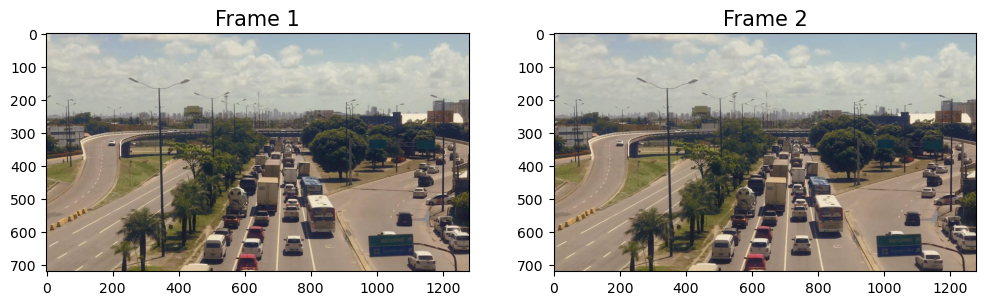

In [5]:
frame1 = cv2.imread('../data/frame1.jpg')
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

frame2 = cv2.imread('../data/frame2.jpg')
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(12,8))

ax[0].imshow(frame1)
ax[1].imshow(frame2)

ax[0].set_title('Frame 1', fontsize=15)
ax[1].set_title('Frame 2', fontsize=15)

plt.show()

# <span style='color:#ff5f27'> 🦅 BirdViewTransformer

In [6]:
# Get image shapes
IMAGE_H, IMAGE_W = frame1.shape[:2]

points = np.array([
    [530, 560],                # Top Left 
    [890, 560],                # Top Right
    [970, IMAGE_H],            # Bottom Right
    [400, IMAGE_H],            # Bottom Left
])

# bounding_boxes1, labels1 = get_yolo_annotation(results1)
# bounding_boxes2, labels2 = get_yolo_annotation(results2)

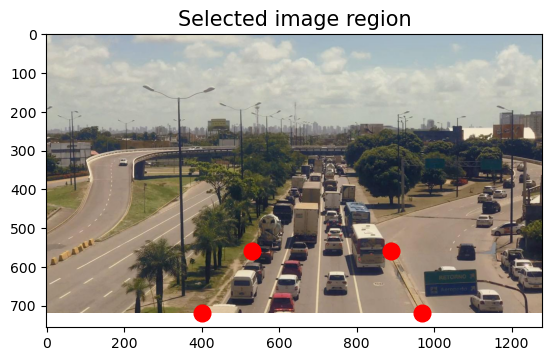

In [7]:
transformer_cam = BirdViewTransformer(
    frame1,
    points
)
transformer_cam

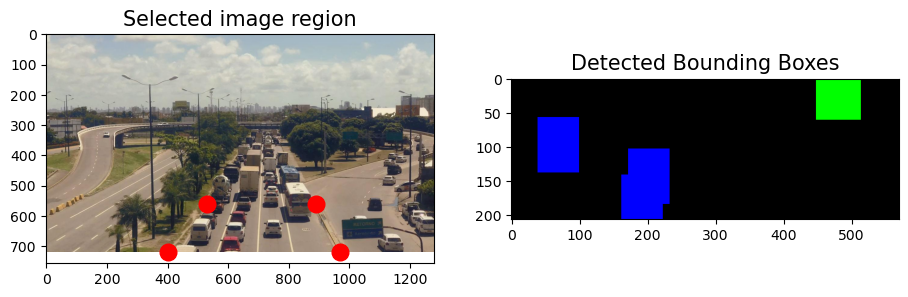

In [8]:
image_normalized = transformer_cam.bird_view_transformation(
    bounding_boxes[0],
    labels[0],
    object_ids[0]
)

transformer_cam.show_results(image_normalized)

In [9]:
len(transformer_cam.id_present)

0

---

### <span style='color:#ff5f27'> ⚠️ Order Centres Problem </span>
Bounding Box Centres are not ordered correctly. As a result wrong angles.
- Add a new attribute to save filtered and normalized centres.
- Add new objects as they are
Try the next:
1. Keep original .bb_centres_transformed.
2. Keep normalized centres in .bb_centres_transformed.


In [10]:
vector1 = np.array([[
        [     65.375,       136.9], #1
        [     336.21,     -34.522], #2
        [     66.765,       29.19], #3
        [     193.06,      146.27], #4
        [     187.82,     -1.7111], #5
        [     347.12,      130.14]]]) #6

vector2 = np.array([[
        [     487.32,     -27.618],
        [     65.217,      140.07],
        [     66.189,      31.705],
        [     336.49,      -37.12],
        [     193.22,      145.29],
        #[     188.48,      -1.667],
        [     346.35,      130.47]
]])

object_ids1 = np.array([1, 2, 3, 4, 5, 6])
object_ids2 = np.array([7, 1, 3, 2, 4,  6])#5,

In [11]:
def zip_vectors(vectors, object_ids):
    assert len(vectors) == len(object_ids)
    return {object_id:vector for vector, object_id in zip(vectors, object_ids)}

In [12]:
def sort_vector(vector_prev, vector_curr, ids_prev, ids_curr):
    # Create a dictionary of the next format {object_id: object_centre}
    zip_vector_prev = zip_vectors(vector_prev[0], ids_prev)
    zip_vector_curr = zip_vectors(vector_curr[0], ids_curr)

    # Filter zip_vector_curr to keep only those objects which are present in zip_vector_prev
    vectors_curr_present = {
        key:value 
        for key, value 
        in zip_vector_curr.items() 
        if key in zip_vector_prev.keys()
    }
    
    # Sort vectors_curr_present to have the same order as zip_vector_prev
    sorted_vectors_present = {
        key : vectors_curr_present[key]
        for key 
        in zip_vector_prev.keys() 
        if key in vectors_curr_present.keys()
    }
    
    # Get intersection of keys in both dictionaries
    common_keys = sorted_vectors_present.keys() & zip_vector_prev.keys()  
    
    # Connect object centers for common id
    common_objects = {
        key: [sorted_vectors_present[key], zip_vector_prev[key]]
        for key 
        in common_keys
    }
    
    # Find new object ids
    curr_diff = list(set(ids_curr) - set(common_objects.keys()))

    # Add new objects
    if len(curr_diff) != 0:
        for key in curr_diff:
            common_objects[key] = [zip_vector_curr[key], zip_vector_curr[key]]
    
    return common_objects

In [13]:
vector2

array([[[487.32 , -27.618],
        [ 65.217, 140.07 ],
        [ 66.189,  31.705],
        [336.49 , -37.12 ],
        [193.22 , 145.29 ],
        [346.35 , 130.47 ]]])

In [14]:
common_objects = sort_vector(vector1, vector2, object_ids1, object_ids2)
common_objects

{1: [array([ 65.217, 140.07 ]), array([ 65.375, 136.9  ])],
 2: [array([336.49, -37.12]), array([336.21 , -34.522])],
 3: [array([66.189, 31.705]), array([66.765, 29.19 ])],
 4: [array([193.22, 145.29]), array([193.06, 146.27])],
 6: [array([346.35, 130.47]), array([347.12, 130.14])],
 7: [array([487.32 , -27.618]), array([487.32 , -27.618])]}

In [15]:
zip_labels = zip_vectors(labels[0], object_ids[0])
zip_labels

{7: 'car', 6: 'car', 5: 'car', 4: 'car', 3: 'car', 2: 'car', 1: 'bus'}

In [16]:
labels_curr = [zip_labels[key] for key in common_objects.keys()]
labels_curr

['bus', 'car', 'car', 'car', 'car', 'car']

---
### <span style='color:#ff5f27'> ⚠️ Normalization Problem </span>

> Sometimes model predictions differs. For example bb can be cut and as a result - shifted center -> wrong angle.
    
📝 What to do:
- [0, box_len / 4) - keep unchanged.
- [box_len / 4, box_len / 2) - divide distance between BB centres by 2.
- [box_len / 2, +inf) - remove object.

    
- Object can't move back
- If X in specific range - keep X the same.

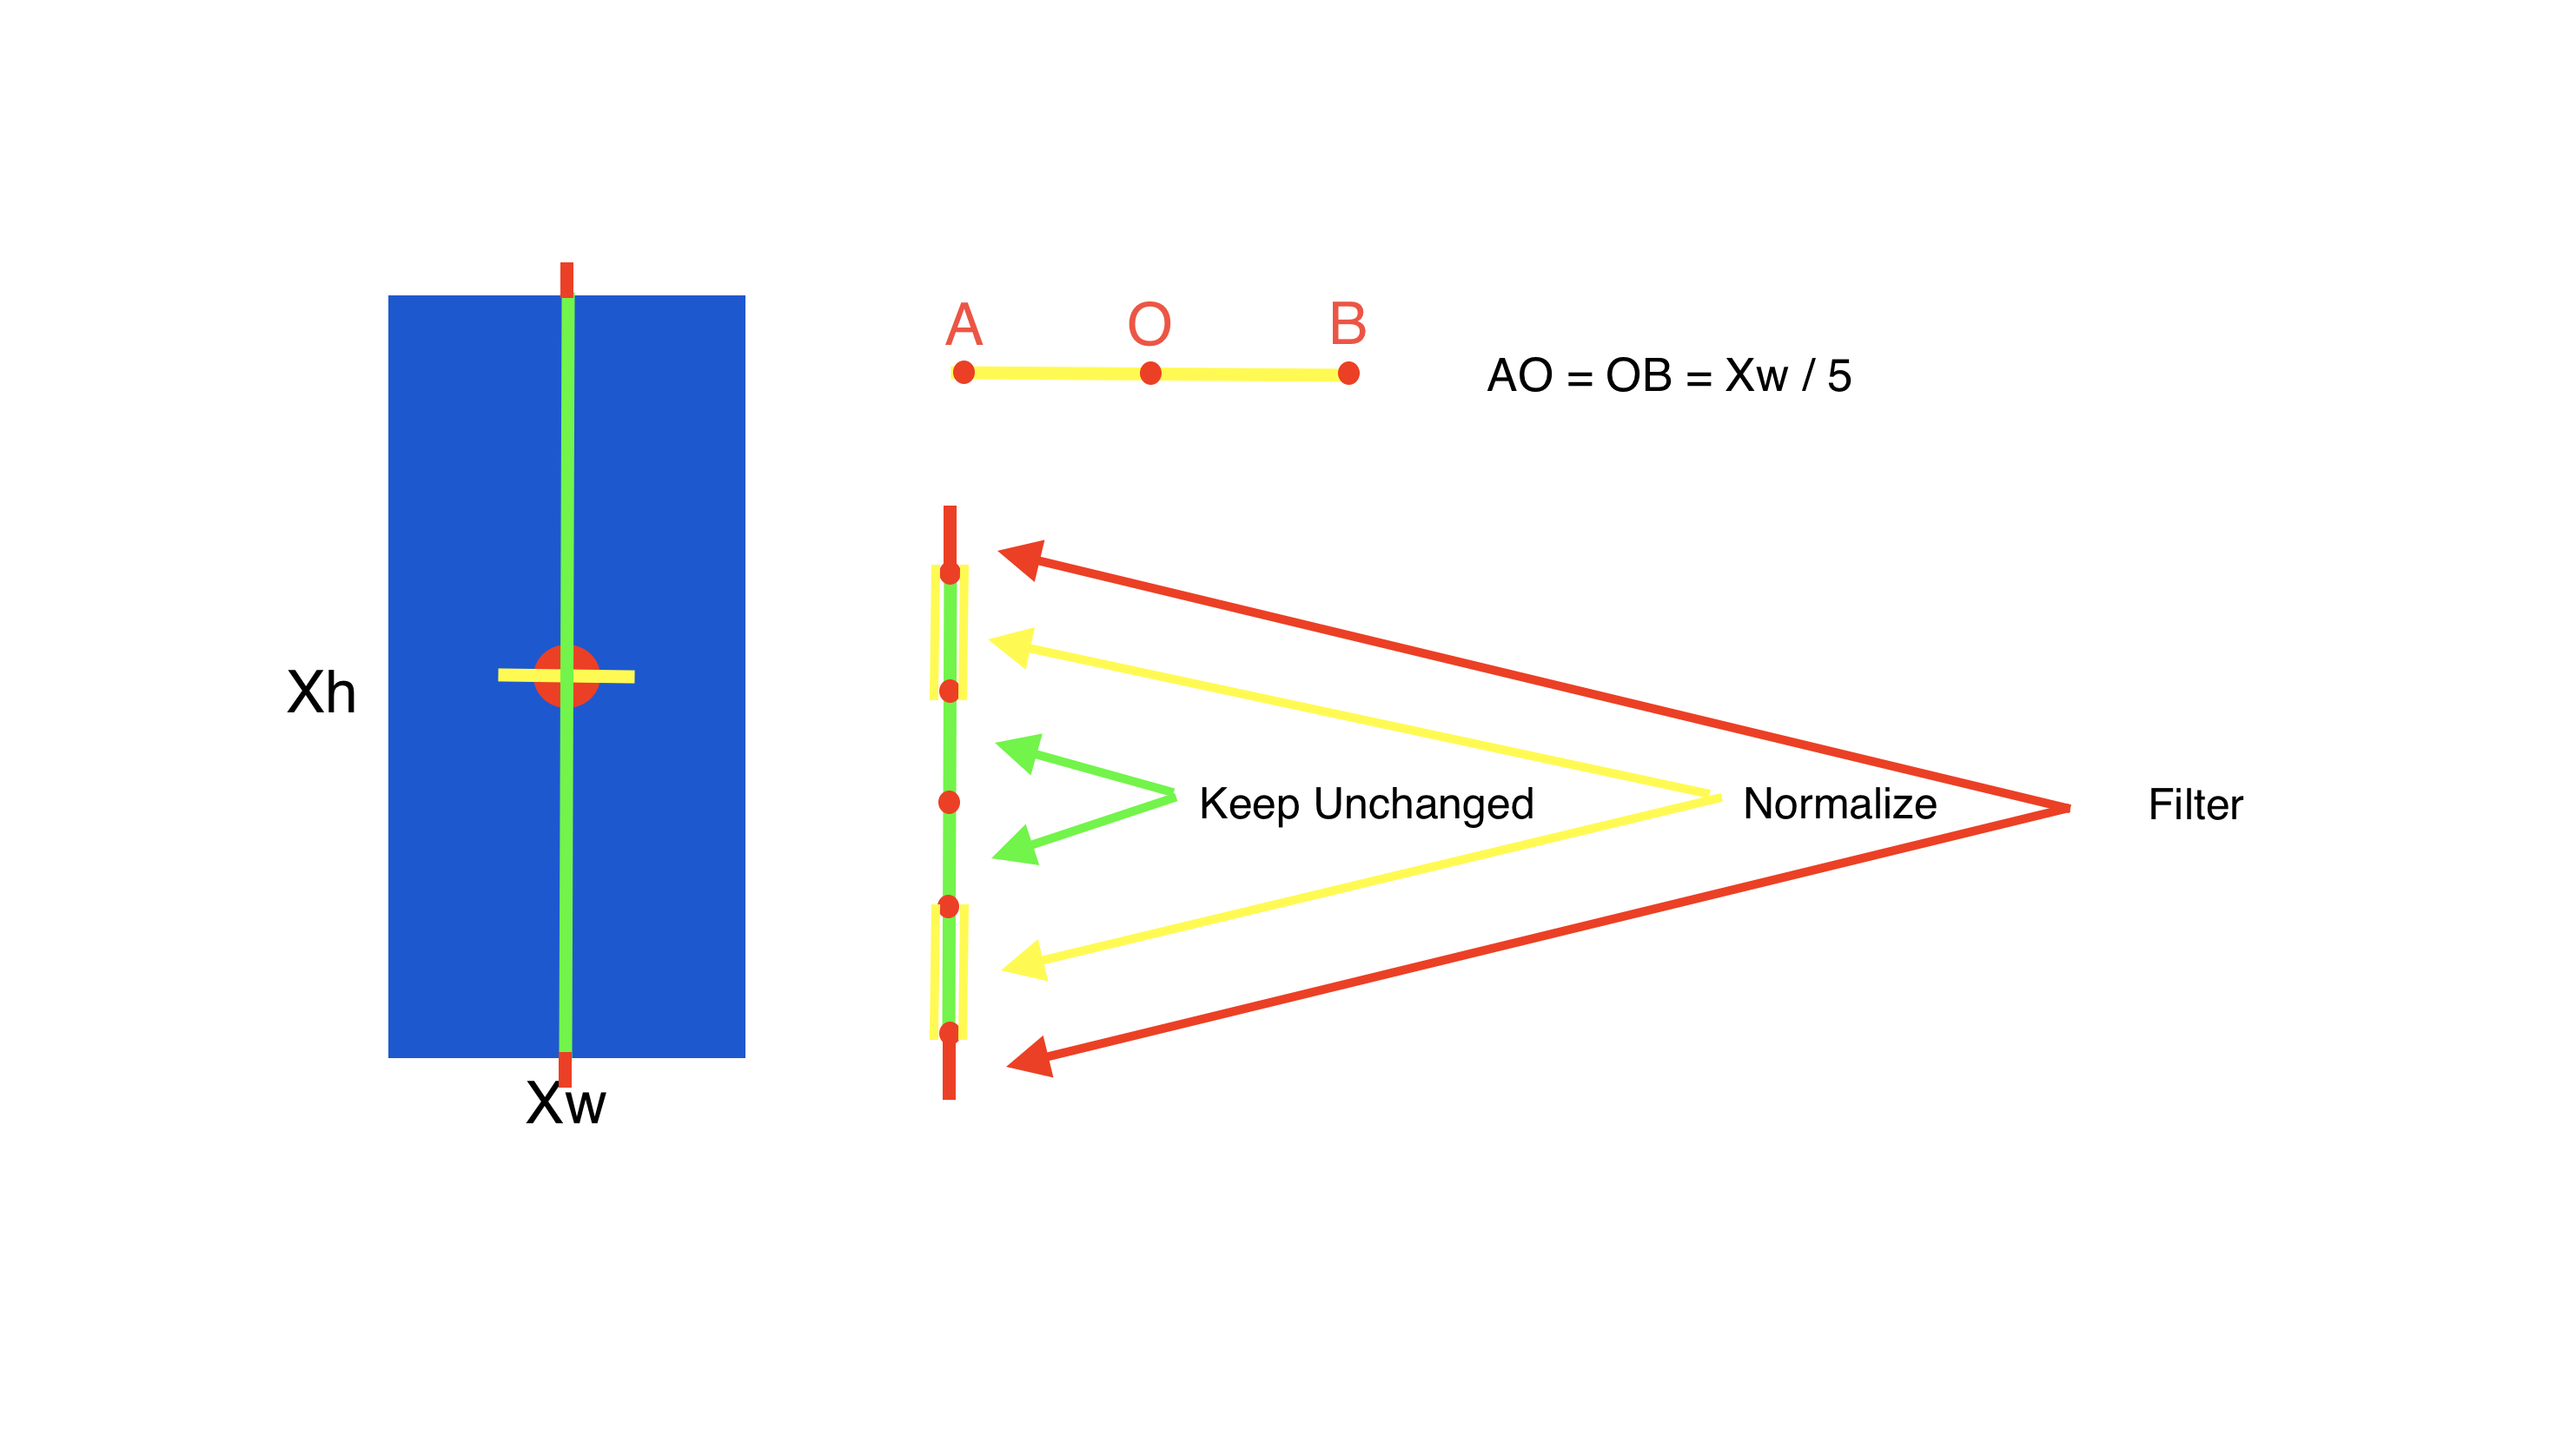

In [17]:
def normalize_centre(centre_prev:np.array, centre:np.array, label):
    # Make a copy of current centre coordinates
    centre_normalized = centre.copy()
    # Retrieve box shapes of required class
    #width, height = self.box_shapes[label]
    width, height = transformer_cam.box_shapes[label]
    
    # Define filters
    filter_normalize = int(height / 4)
    filter_remove = int(height / 2)
    
    # Calculate a distance by which the object moved forward
    distance = abs(centre[1] - centre_prev[1])
    
    # If distance is lower than filter_normalize - no need to change coordinates
    
    # If distance is more that filter_normalize and less than filter_remove
    # then move centre back by half of passed distance
    # If objects moves forward - move back by half of passed distance
    # If objects moves back - move forward by half of passed distance
    if (distance >= filter_normalize) and (distance < filter_remove):
        if (centre[1] - centre_prev[1]) >= 0:
            centre_normalized[1] -= int(distance / 2) 
        else:
            centre_normalized[1] += int(distance / 2) 
        
    # If distance is more than filter_remove - object is treated as an outlier -> remove
    if distance >= filter_remove:
        return None
    
    # Calculate a shift distance left/right
    distance_turn = centre[0] - centre_prev[0]
    
    # Define a filter
    filter_normalize_turn = int(width / 5)
    
    # If shift distance is in +-filter_normalize_turn range - 
    # shift is treated as a model inaccuracy so keep older x value
    if abs(distance_turn) < filter_normalize_turn:
        centre_normalized[0] = centre_prev[0]        
    
    return centre_normalized 

In [18]:
normalize_centre(
    np.array([ 65.217, 140.07 ]),
    np.array([ 65.375, 156.9  ]),
    'car'
)

array([ 65.217, 156.9  ])

In [19]:
[*(
    normalize_centre(centre_prev, centre_curr, 'car')
    for centre_prev, centre_curr
    in {
        1 : [np.array([ 65.217, 140.07 ]), np.array([ 65.375, 136.9  ])], # Normalize X
        4 : [np.array([ 65.217, 140.07 ]), np.array([ 80,     136.9  ])], # Keep Unchanged
        2 : [np.array([ 65.217, 140.07 ]), np.array([ 65.375, 266.9  ])], # Filter
        3 : [np.array([ 65.217, 140.07 ]), np.array([ 65.217, 166.9  ])]  # Normalize Y
    }.values()
    if normalize_centre(centre_prev, centre_curr, 'car') is not None
)]

[array([ 65.217, 136.9  ]), array([ 80. , 136.9]), array([ 65.217, 153.9  ])]

In [20]:
vector1 = np.array([[
        [     65.375,       136.9],
        [     336.21,     -34.522],
        [     66.765,       29.19],
        [     193.06,      146.27],
        [     187.82,     -1.7111],
        [     347.12,      130.14]]])

vector2 = np.array([[
        [     65.217,      140.07],
        [     336.49,      -37.12],
        [     66.189,      31.705],
        [     193.22,      145.29],
        [     188.48,      -1.667],
        [     346.35,      130.47]]])


normalized_cent = np.array([
    normalize_centre(
        cent1,
        cent2,
        'car'
    )
    for cent1, cent2
    in zip(vector1[0], vector2[0])
])
normalized_cent

array([[ 65.375, 140.07 ],
       [336.21 , -37.12 ],
       [ 66.765,  31.705],
       [193.06 , 145.29 ],
       [187.82 ,  -1.667],
       [347.12 , 130.47 ]])

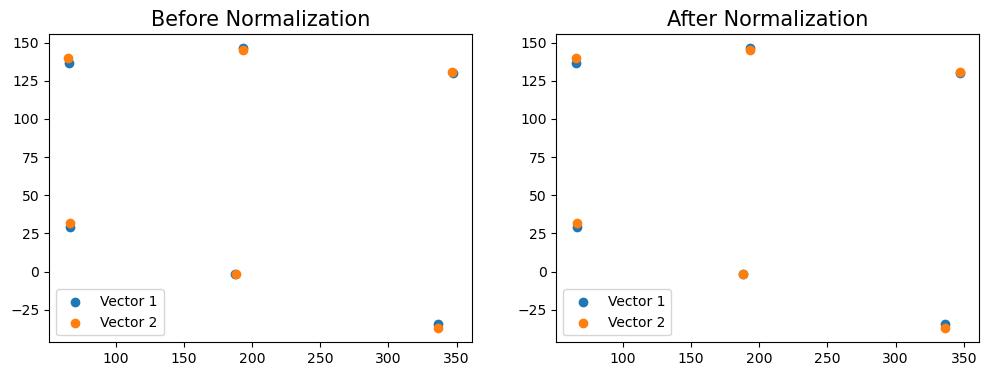

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

x1, y1 = vector1[:, :, 0], vector1[:, :, 1]
x2, y2 = vector2[:, :, 0], vector2[:, :, 1]

ax[0].scatter(x1, y1, label='Vector 1')
ax[0].scatter(x2, y2, label='Vector 2')

x1, y1 = vector1[:, :, 0], vector1[:, :, 1]
x2, y2 = normalized_cent[:, 0], normalized_cent[:, 1]

ax[1].scatter(x1, y1, label='Vector 1')
ax[1].scatter(x2, y2, label='Vector 2')

ax[0].set_title('Before Normalization', fontsize=15)
ax[1].set_title('After Normalization', fontsize=15)

ax[0].legend()
ax[1].legend()
plt.show()

---
## <span style='color:#ff5f27'> 👩🏻‍🔬 Check </span>

In [22]:
[centres[-1] for centres in common_objects.values()]

[array([ 65.375, 136.9  ]),
 array([336.21 , -34.522]),
 array([66.765, 29.19 ]),
 array([193.06, 146.27]),
 array([347.12, 130.14]),
 array([487.32 , -27.618])]

In [23]:
common_objects

{1: [array([ 65.217, 140.07 ]), array([ 65.375, 136.9  ])],
 2: [array([336.49, -37.12]), array([336.21 , -34.522])],
 3: [array([66.189, 31.705]), array([66.765, 29.19 ])],
 4: [array([193.22, 145.29]), array([193.06, 146.27])],
 6: [array([346.35, 130.47]), array([347.12, 130.14])],
 7: [array([487.32 , -27.618]), array([487.32 , -27.618])]}

In [24]:
normalized_current = [*(
    normalize_centre(centre_prev, centre_curr, label)
    for (centre_prev, centre_curr), label
    in zip(common_objects.values(), labels_curr)
    if normalize_centre(centre_prev, centre_curr, label) is not None
)]
normalized_current

[array([ 65.217, 136.9  ]),
 array([336.49 , -34.522]),
 array([66.189, 29.19 ]),
 array([193.22, 146.27]),
 array([346.35, 130.14]),
 array([487.32 , -27.618])]

In [25]:
for value, normalized_value in zip(common_objects.values(), normalized_current):
    value[-1] = normalized_value

In [26]:
[*common_objects.values()]

[[array([ 65.217, 140.07 ]), array([ 65.217, 136.9  ])],
 [array([336.49, -37.12]), array([336.49 , -34.522])],
 [array([66.189, 31.705]), array([66.189, 29.19 ])],
 [array([193.22, 145.29]), array([193.22, 146.27])],
 [array([346.35, 130.47]), array([346.35, 130.14])],
 [array([487.32 , -27.618]), array([487.32 , -27.618])]]

In [27]:
angles_normalized = [
    transformer_cam.get_vector_angle(
        centre[0],
        centre[1]
    ) 
    for centre 
    in common_objects.values()
]
angles_normalized

[90, 90, 90, 90, 90, 90]

In [28]:
angles = [
    transformer_cam.get_vector_angle(coords[0], coords[1])
    for coords 
    in zip(
        vector1[0],
        vector2[0]
    )
]
angles

[-87, -83, -77, -80, 3, -23]

---

In [29]:
image_normalized = np.zeros_like(image_normalized)

for centre, angle, label in zip(vector1[0], angles_normalized, ['car','car','car','car','car','car']):
    image_normalized = transformer_cam.plot_normalized_bounding_box(image_normalized,centre,angle,label)

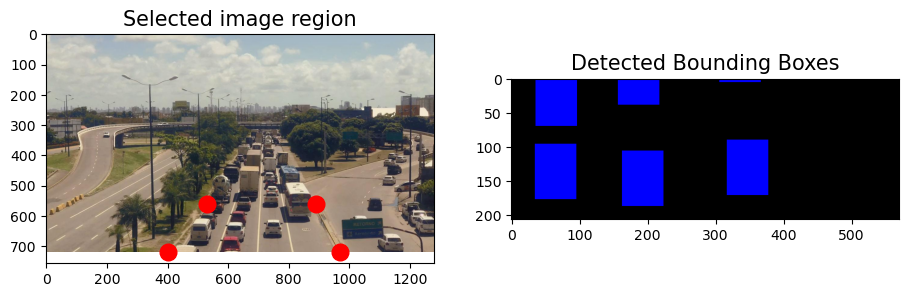

In [30]:
transformer_cam.show_results(image_normalized)

[-87, -83, -77, -80, 3, -23]


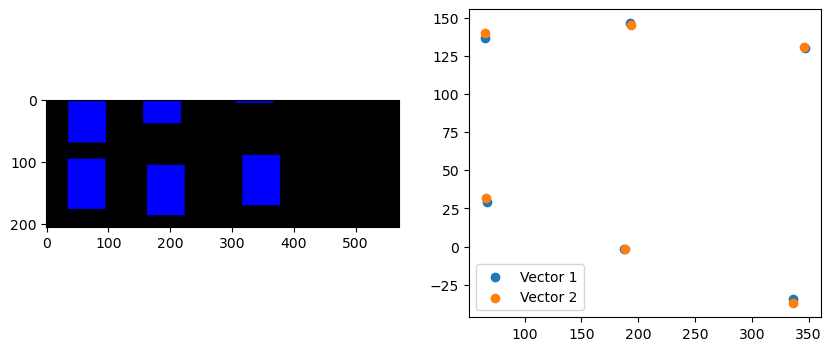

In [31]:
print(angles)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].imshow(image_normalized)

x1, y1 = vector1[:, :, 0], vector1[:, :, 1]
x2, y2 = vector2[:, :, 0], vector2[:, :, 1]

ax[1].scatter(x1, y1, label='Vector 1')
ax[1].scatter(x2, y2, label='Vector 2')

plt.legend()
plt.show()

---

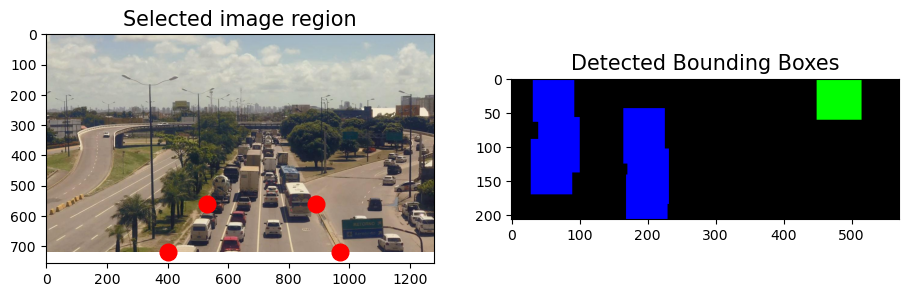

In [32]:
image_normalized2 = transformer_cam.bird_view_transformation(
    bounding_boxes[2],
    labels[2],
    object_ids[2]
)

transformer_cam.show_results(image_normalized2)

In [33]:
transformer_cam.bb_centres_transformed_prev

array([[[ 69.96302666,  97.12381771],
        [192.72687946, 181.70291126],
        [202.13990974, 143.14313346],
        [481.48524235, -22.14865963]]])

In [34]:
transformer_cam.bb_centres_transformed_curr

array([[[195.53351009,  84.33716306],
        [ 62.46506986,  23.32335329],
        [ 59.78911293, 129.85925334],
        [ 70.22260669,  94.34256055],
        [199.64562142, 181.70291126],
        [201.14378071, 142.02094647],
        [482.39041347, -29.92864984]]])

In [35]:
transformer_cam.object_ids_prev

array([5, 3, 2, 1])

In [36]:
transformer_cam.object_ids_curr

array([12, 11,  8,  5,  3,  2,  1])

In [37]:
transformer_cam.common_objects

{1: [array([482.39041347, -29.92864984]), array([482.39041347, -22.14865963])],
 2: [array([201.14378071, 142.02094647]), array([201.14378071, 143.14313346])],
 3: [array([199.64562142, 181.70291126]), array([199.64562142, 181.70291126])],
 5: [array([70.22260669, 94.34256055]), array([70.22260669, 97.12381771])],
 8: [array([ 59.78911293, 129.85925334]), array([ 59.78911293, 129.85925334])],
 11: [array([62.46506986, 23.32335329]), array([62.46506986, 23.32335329])],
 12: [array([195.53351009,  84.33716306]),
  array([195.53351009,  84.33716306])]}

In [38]:
transformer_cam.angles_normalized

[90, 90, 90, 90, 90, 90, 90]

---
## <span style='color:#ff5f27'> 📈 Analytics</span>

Count the number of unique centers that have crossed a specific image region. 

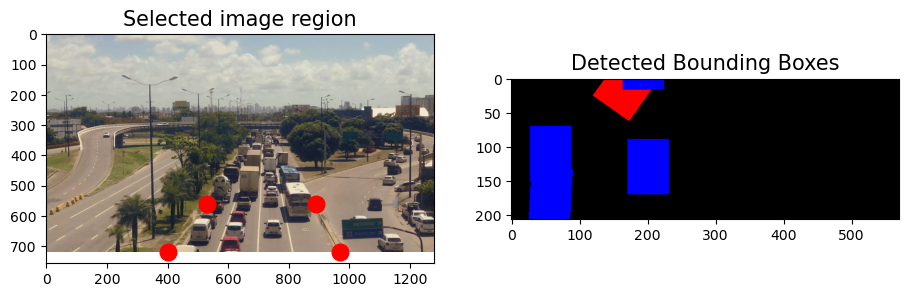

In [39]:
image_normalized2 = transformer_cam.bird_view_transformation(
    bounding_boxes[51],
    labels[51],
    object_ids[51]
)

transformer_cam.show_results(image_normalized2)

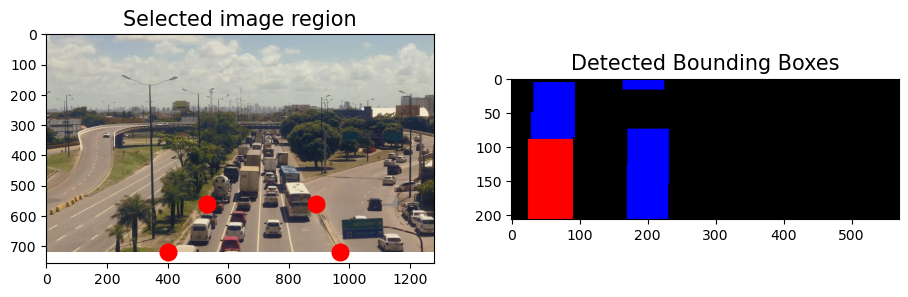

In [40]:
image_normalized2 = transformer_cam.bird_view_transformation(
    bounding_boxes[52],
    labels[52],
    object_ids[52]
)

transformer_cam.show_results(image_normalized2)

In [41]:
def analyze():
    bot_border, top_border = transformer_cam.analyze_region
    
    for centre, obj_id in zip(np.array(transformer_cam.centres_curr), transformer_cam.ids_curr):
        centre_y = centre[-1]

        if (centre_y <= top_border) and (centre_y >= bot_border) and (obj_id not in transformer_cam.id_present):
            transformer_cam.id_present.append(obj_id)
    
    return self

In [42]:
id_present = []

bot_border = image_normalized.shape[0] * 0.20
top_border = image_normalized.shape[0] * 0.25

for centre, obj_id in zip(np.array(transformer_cam.centres_curr), transformer_cam.ids_curr):
    centre_y = centre[-1]

    if (centre_y <= top_border) and (centre_y >= bot_border) and (obj_id not in id_present):
        id_present.append(obj_id)
        
print(f'🚗 Amount of cars: {len(id_present)}')

🚗 Amount of cars: 1


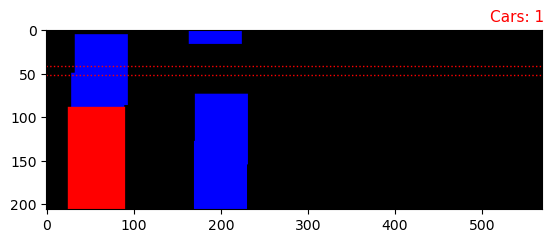

In [43]:
fig, ax = plt.subplots()

ax.imshow(image_normalized2)

# Plot horizontal lines
ax.axhline(
    y=top_border,
    color='red',
    linestyle='dotted',
    linewidth=1
)
ax.axhline(
    y=bot_border,
    color='red', 
    linestyle='dotted',
    linewidth=1
)

# Add text to the figure
ax.text(540, -10, f'Cars: {len(id_present)}', fontsize=11, color='red', ha='center')

plt.show()

In [44]:
transformer_cam.counter

1

---